In [94]:
import random
import os
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [95]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [96]:
train = pd.read_csv('../../DATA/train.csv')
test  = pd.read_csv('../../DATA/test.csv')

In [97]:

new_column_names = {
    'corporation': 'corp',
    'location': 'loc',
    'supply(kg)': 'supply',
    'price(원/kg)': 'price',
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

train['timestamp']  = pd.to_datetime(train['timestamp'])
test['timestamp']  = pd.to_datetime(test['timestamp'])

train['newitem'] = train['item'].str.cat([train['corp'], train['loc']], sep=' ')

In [98]:
# ## Make Date Data
# # 데이터 타입 변경, 열 이름 변경 

# new_column_names = {
#     'corporation': 'corp',
#     'location': 'loc',
#     'supply(kg)': 'supply',
#     'price(원/kg)': 'price',
# }
# train = train.rename(columns=new_column_names)
# test = test.rename(columns=new_column_names)
# train['timestamp']  = pd.to_datetime(train['timestamp'])
# test['timestamp']  = pd.to_datetime(test['timestamp'])

# def get_date_info(data) :
#     # data의 날짜 정보 추출하기 
#     data['year'] = data['timestamp'].dt.year
#     data['month'] = data['timestamp'].dt.month
#     data['day'] = data['timestamp'].dt.day
#     data['weekday'] = data['timestamp'].dt.weekday
#     data['weekofyear'] = data['timestamp'].dt.isocalendar().week
#     data['dayofyear'] = data['timestamp'].dt.dayofyear #해당 년도의 몇 일째 

# def month_to_season(month):
#     if month in [12, 1, 2]:
#         return 'Winter'
#     elif month in [3, 4, 5]:
#         return 'Spring'
#     elif month in [6, 7, 8]:
#         return 'Summer'
#     else:
#         return 'Fall'

    
# get_date_info(train)
# get_date_info(test)

# # 'month' 칼럼을 정수형으로 변환
# train['season'] = train['month'].astype(int).apply(month_to_season)
# test['season'] = test['month'].astype(int).apply(month_to_season)

In [99]:
#가격 시계열 price_data 생성하기 

def before_timeseries_data(train):
    unique_values = train['newitem'].unique()
    # 날짜 범위 생성
    start_date = datetime(2019, 1, 1).date()
    end_date =datetime(2023, 3, 3).date()
    dates = pd.date_range(start_date, end_date, freq='D')

    # 데이터프레임 생성
    price_data = pd.DataFrame(columns=['item'] + dates.strftime('%Y-%m-%d').tolist())
    price_data['item'] = unique_values

    # print(len(price_data)) 39 
    for i in range(len(price_data)) :
        price_data.iloc[i,1:] = train['price'][i*1523 : (i+1)*1523 ]
    price_data['item'] = price_data['item'].astype(str)
    price_data['corp'] = price_data['item'].str[3:4]

    price_data['loca'] = price_data['item'].str[-1:]
    price_data['product'] = price_data['item'].str[:2]
    price_data['product_loca'] =price_data['product'].str.cat(price_data['loca'], sep=' ')
    cols = price_data.columns[-4:]  # 가장 뒤의 3개 열의 열 이름을 선택
    price_data = price_data[cols.tolist() + price_data.columns[:-4].tolist()]  # 열 순서 변경
    
    return price_data

price_data = before_timeseries_data(train)

In [100]:
le = LabelEncoder()
price_data['product_loca'] = le.fit_transform(price_data['product_loca'])
price_df = price_data.copy()

/home/kiwoongyoon/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/kiwoongyoon/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [60]:
def interpolation_function(data) :
    non_zero_data =[value for value in data if value != 0]
    median_price = np.median(non_zero_data[-10: ])
    filled_data = data.copy()
    non_zero_indices = np.where(data!=0)[0]
    if non_zero_indices[-1] != len(data) - 1:
        filled_data[non_zero_indices[-1]+1:] = np.linspace(data[non_zero_indices[-1]], median_price, len(data)-non_zero_indices[-1])[:-1]

    for i in range(len(non_zero_indices)-1) :
        start, end = non_zero_indices[i], non_zero_indices[i+1]
        filled_data[start+1:end] = np.linspace(data[start], data[end], end-start+1)[1:-1]
    

    return filled_data ,median_price

In [61]:
# interpolation 적용하기 
for i in range(len(price_df)) :
    # cres , cbas, crds , bcbs , rdcs, bccs 
    # print(price_df.iloc[i, 4])
    if price_df.iloc[i, 4] in ['CR E S', 'CB A S' , 'CR D S', 'BC B S', 'RD C S' , 'BC C S']: continue
    
    prices = list(price_df.iloc[i , 5:])
    interpolated_prices, median_price = interpolation_function(np.array(prices)) 
    if prices[-1] ==0 :
        print(price_df.iloc[i, 4] , median_price)    
    price_df.iloc[i , 5:] =interpolated_prices 
    

TG D J 1765.0
CR B J 2417.0
CB A J 1500.0
CB E J 750.0
RD E S 676.5


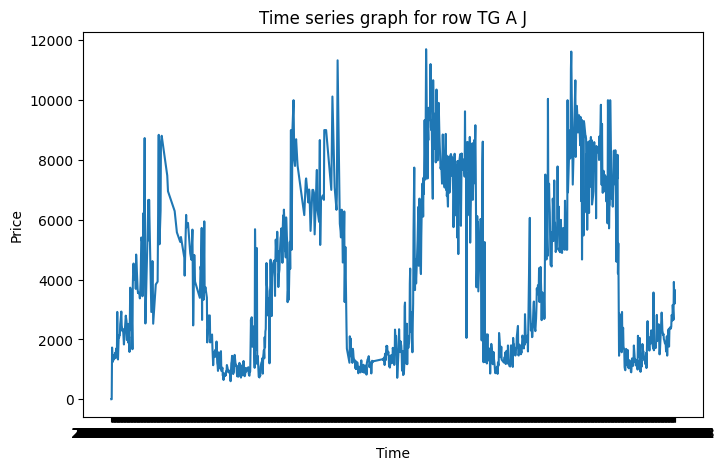

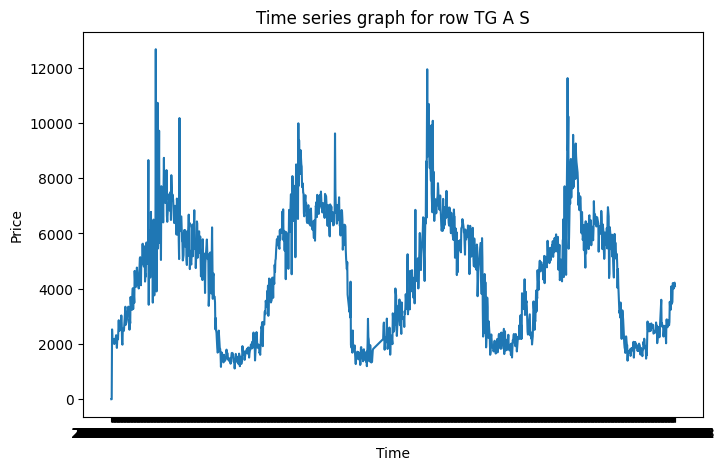

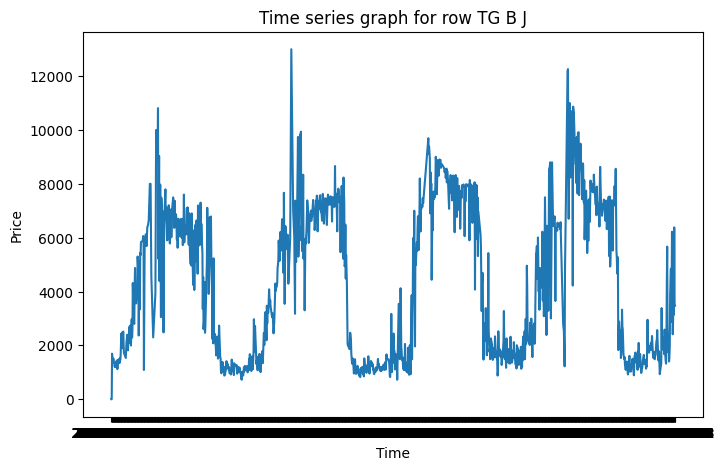

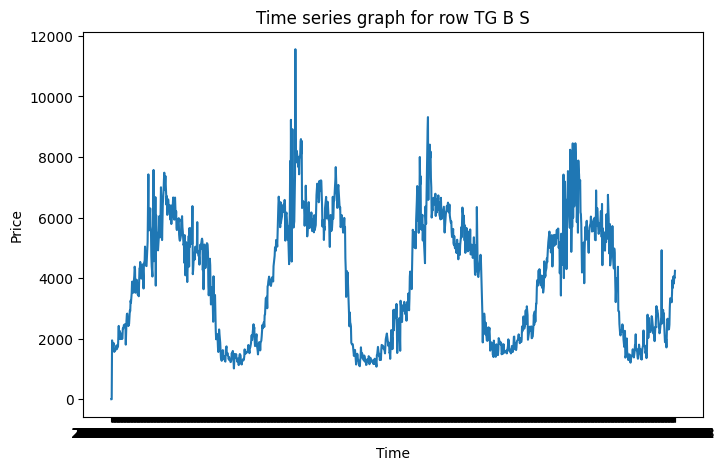

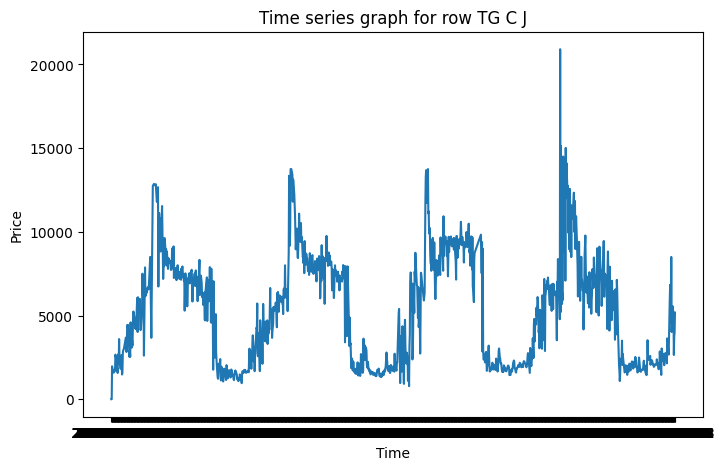

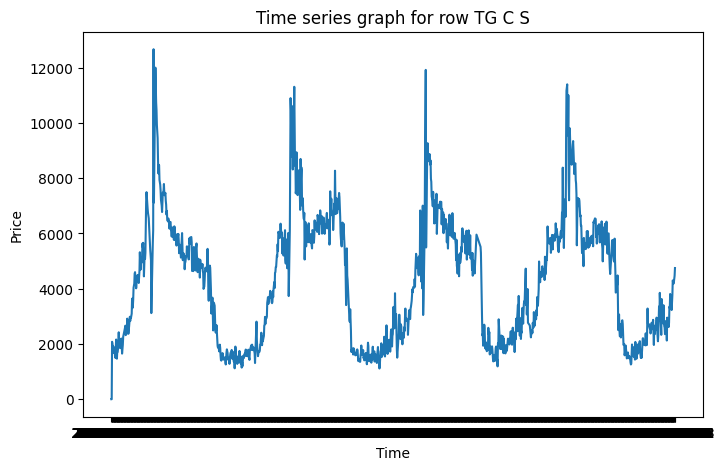

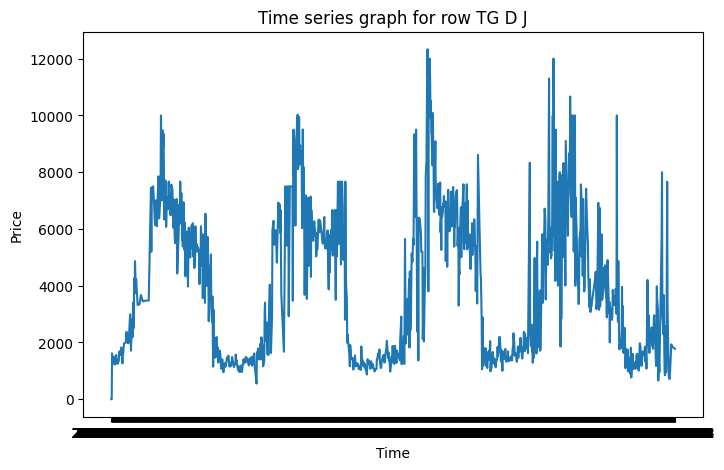

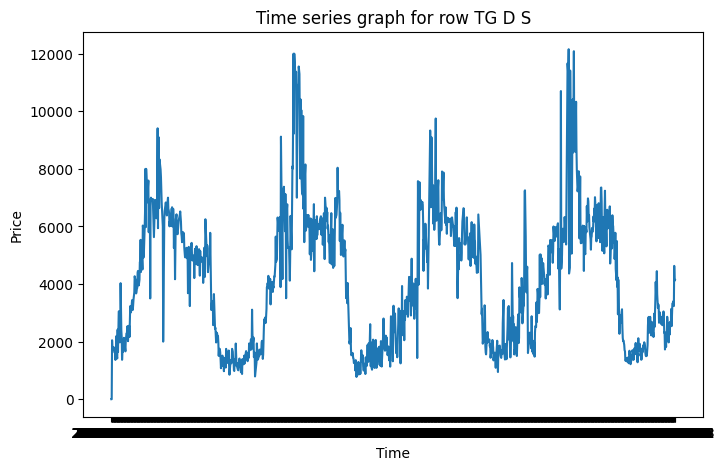

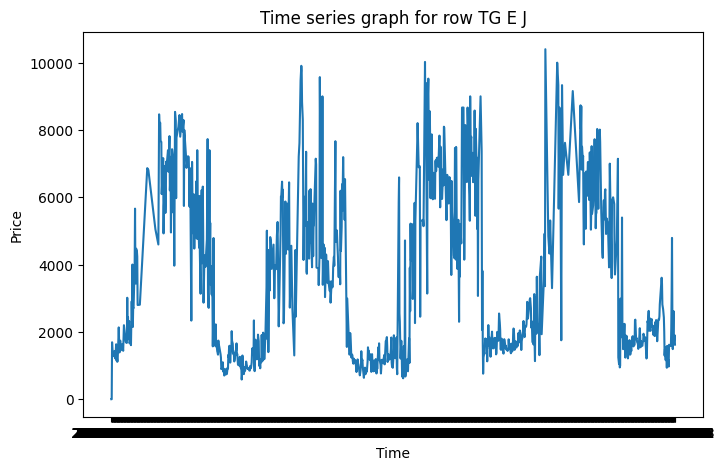

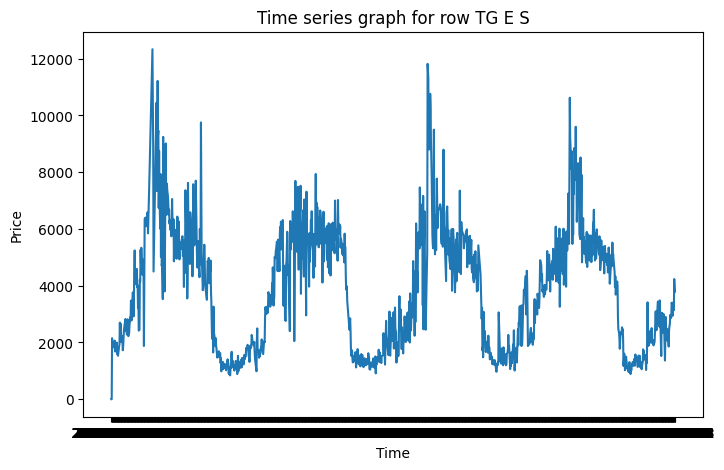

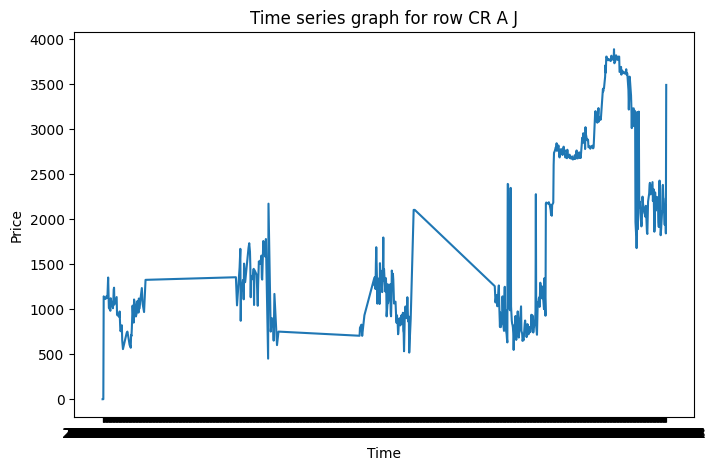

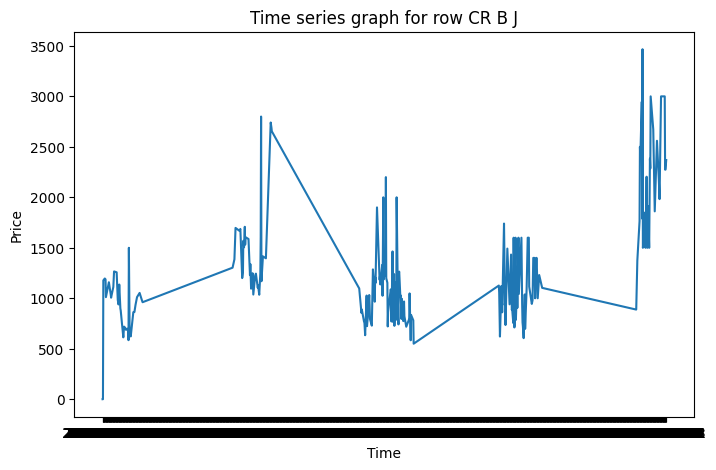

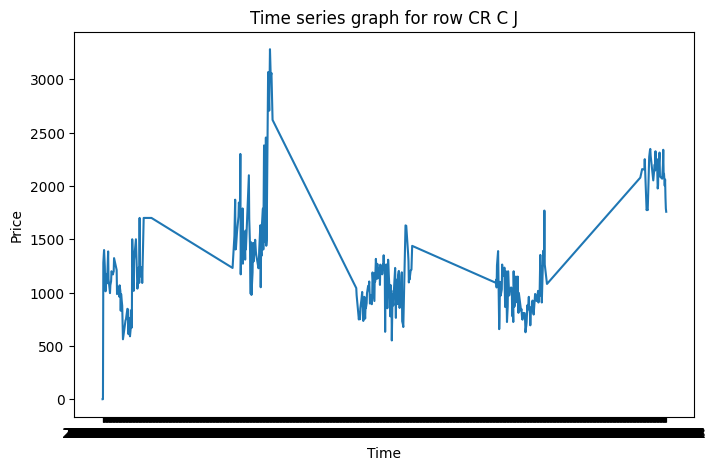

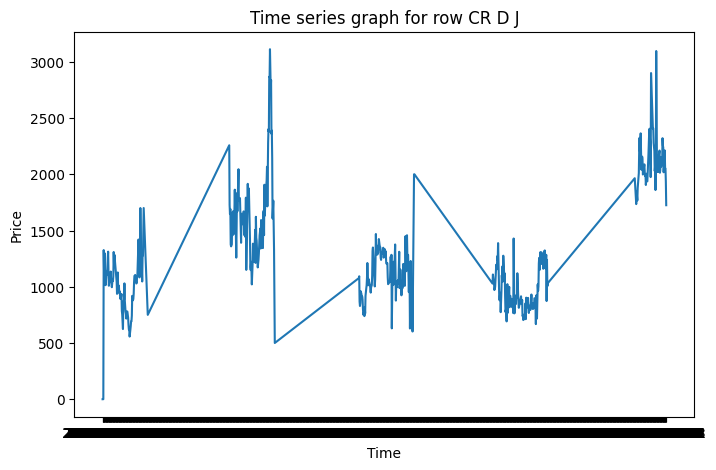

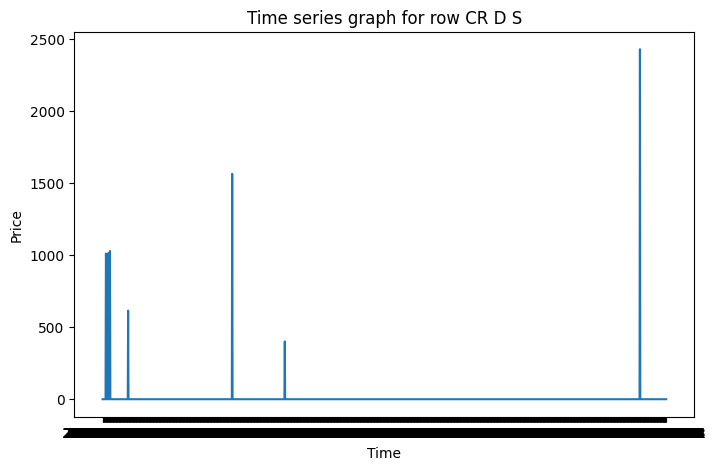

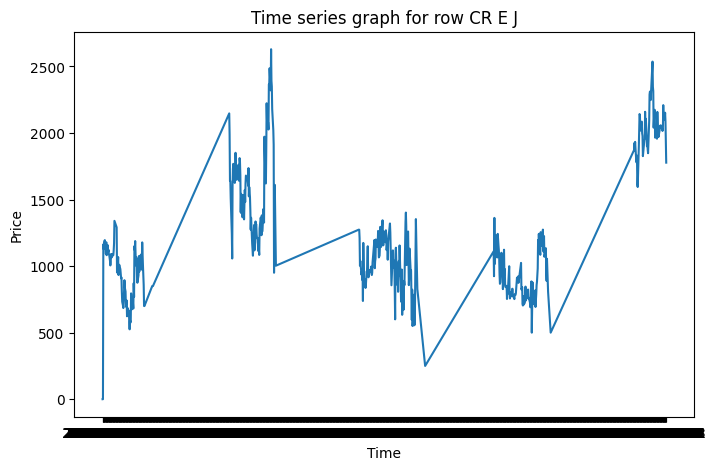

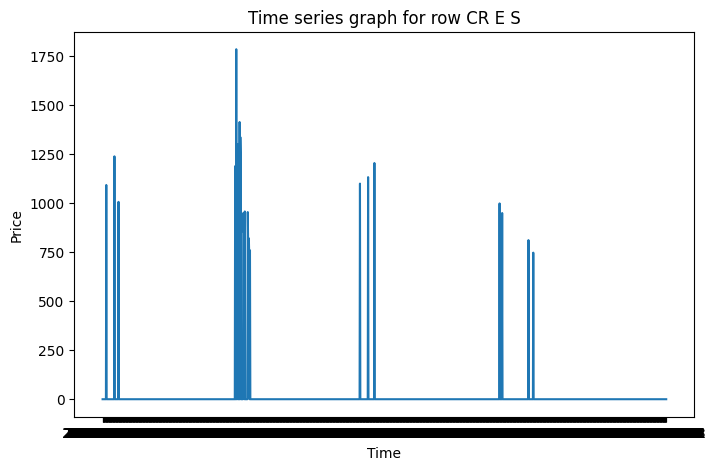

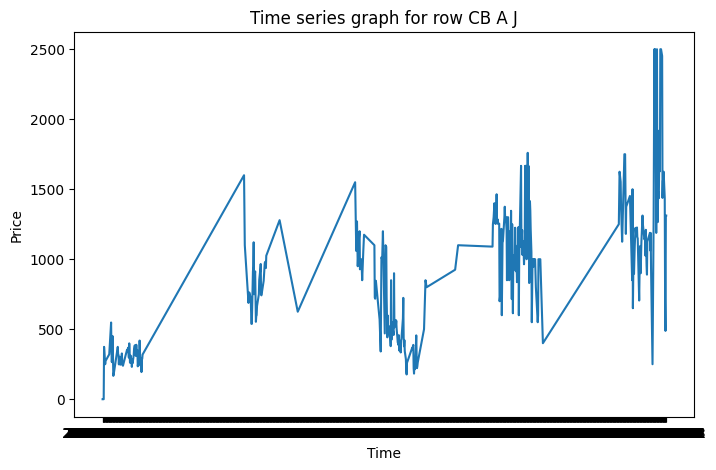

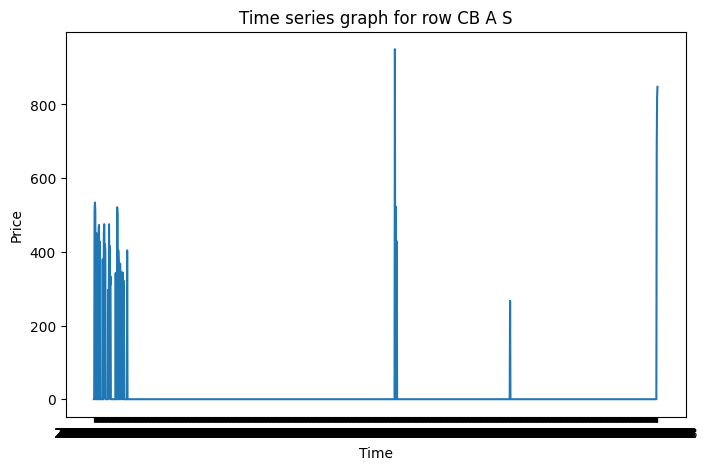

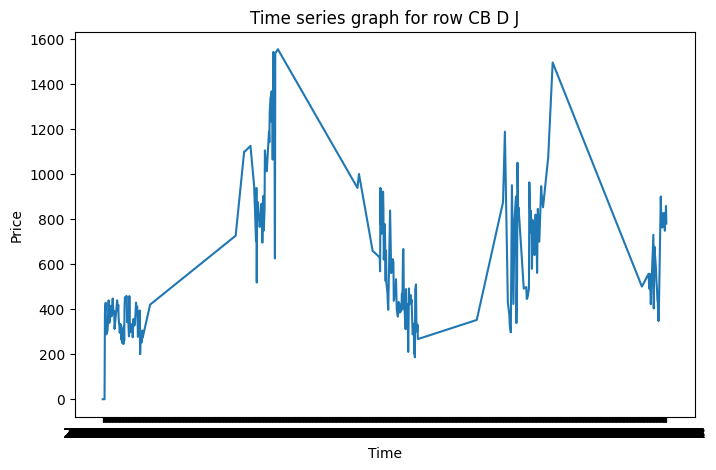

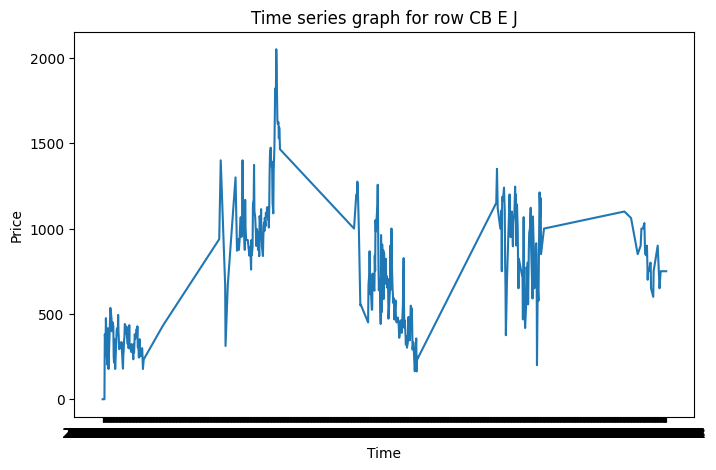

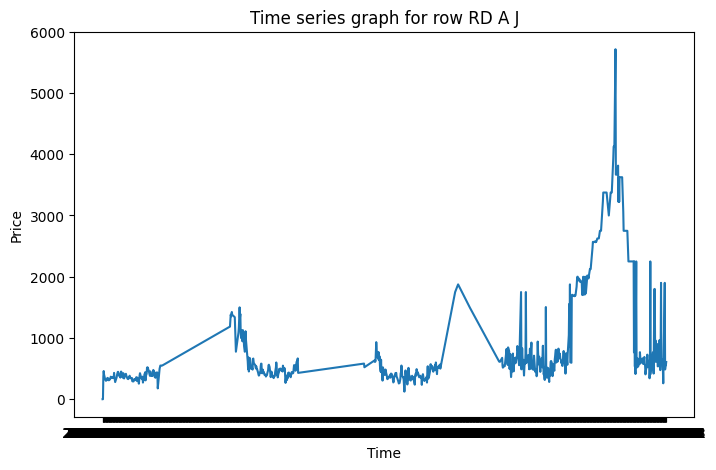

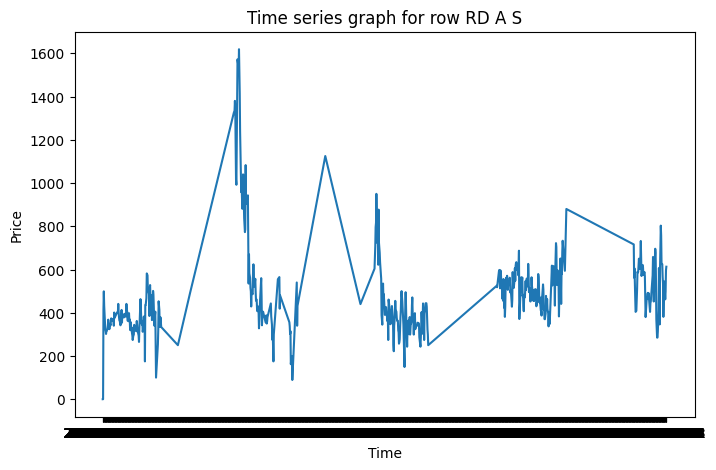

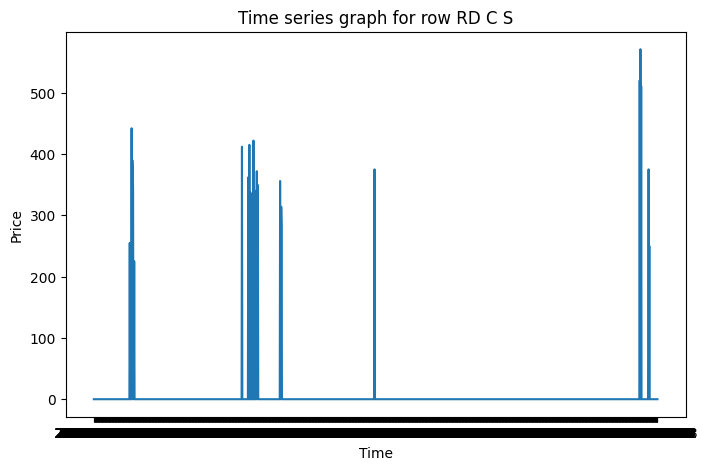

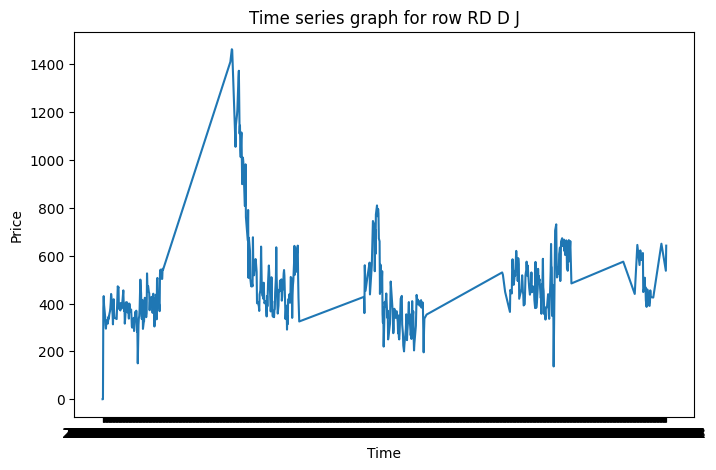

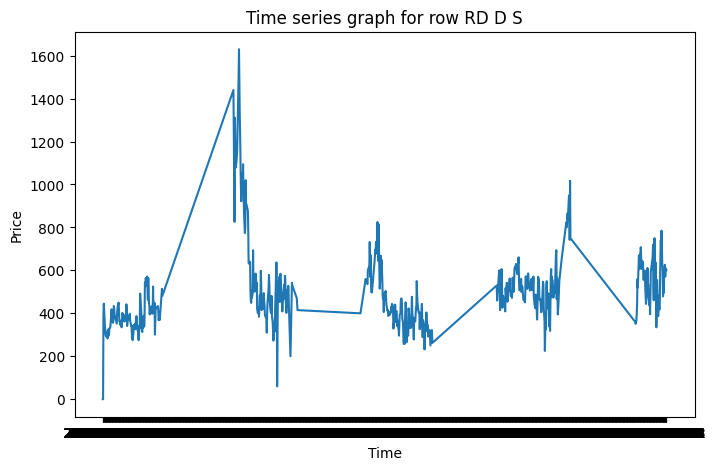

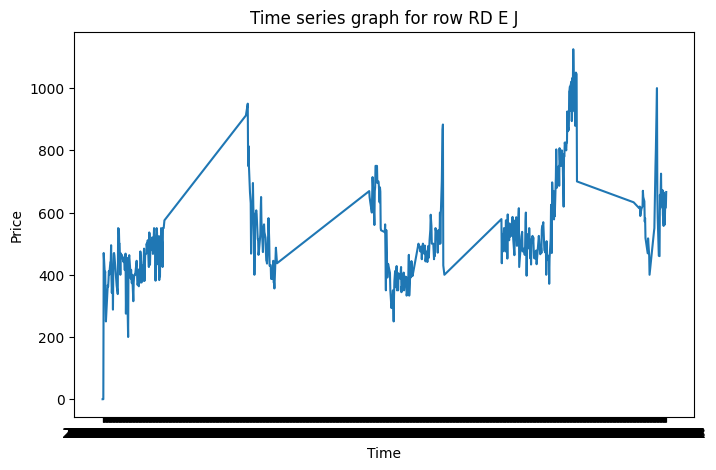

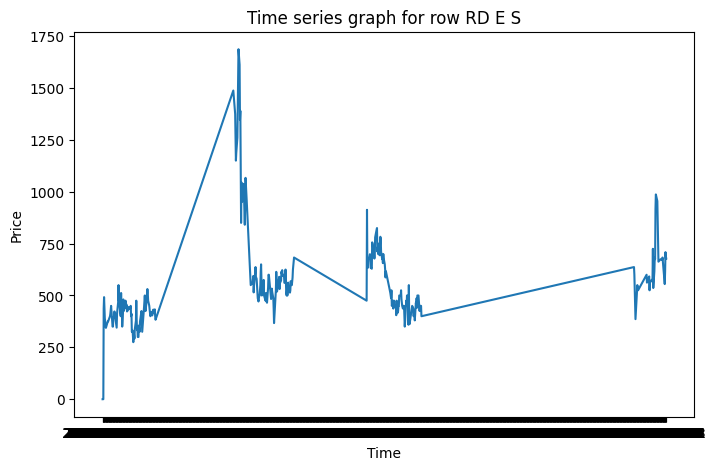

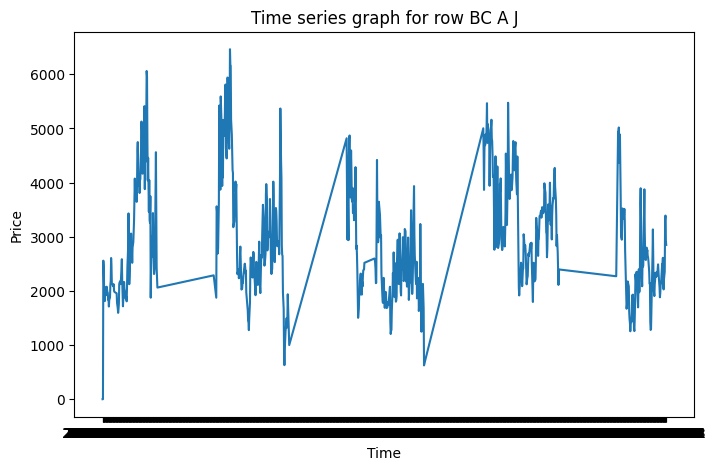

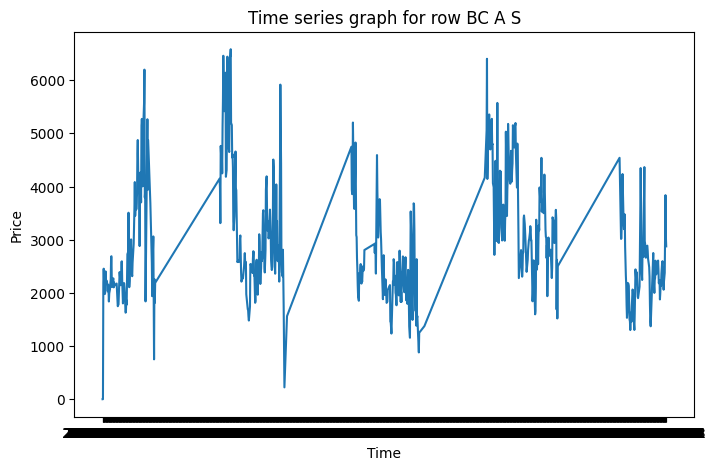

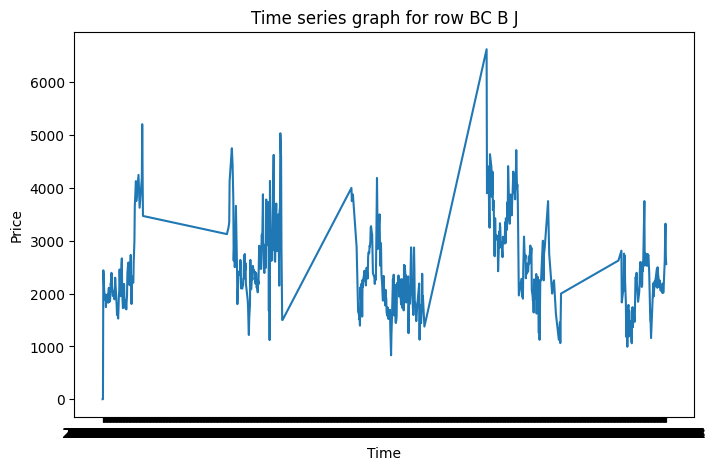

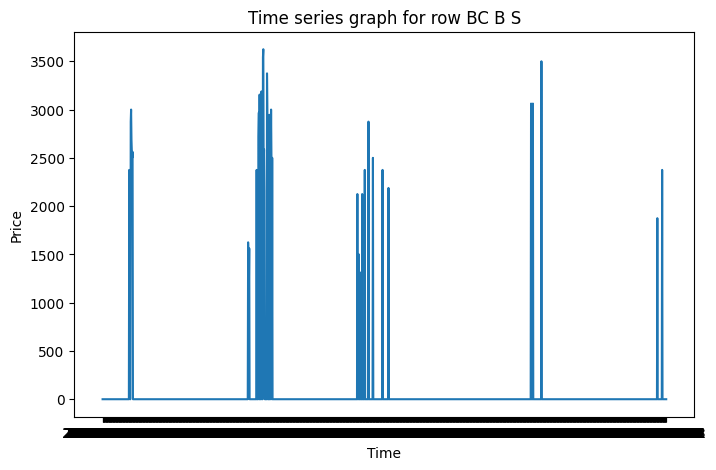

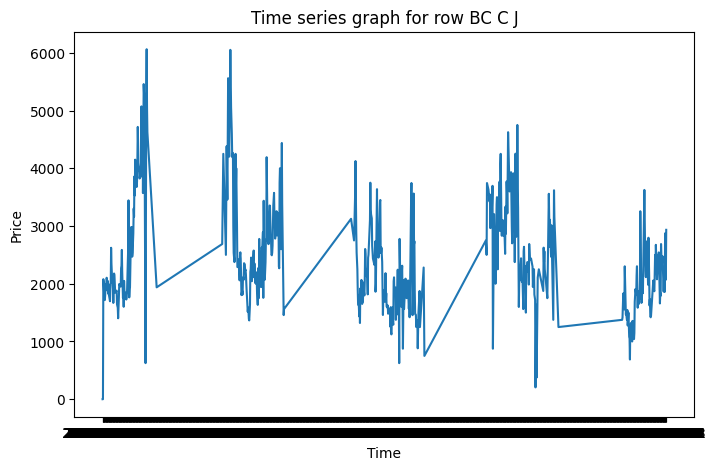

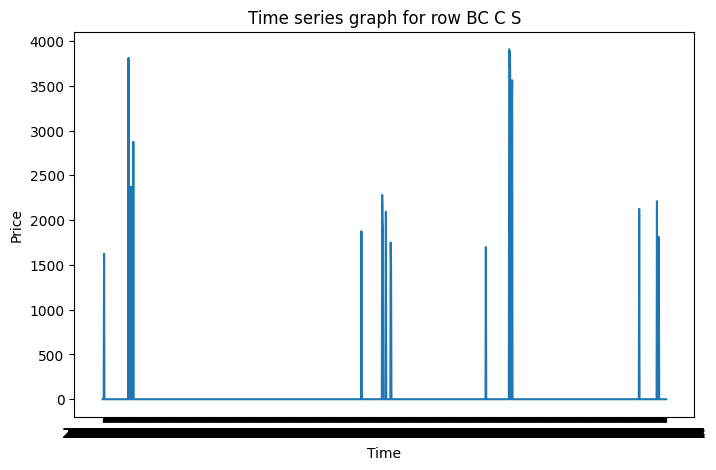

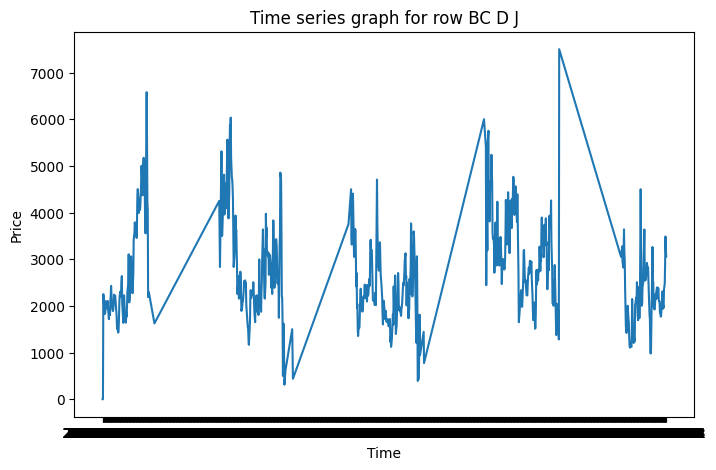

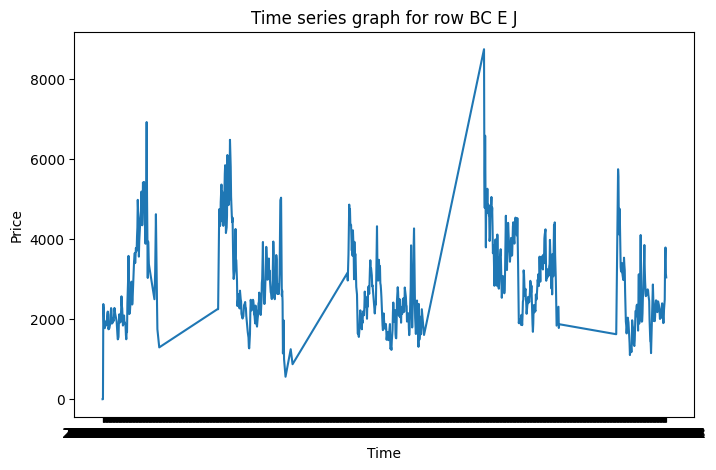

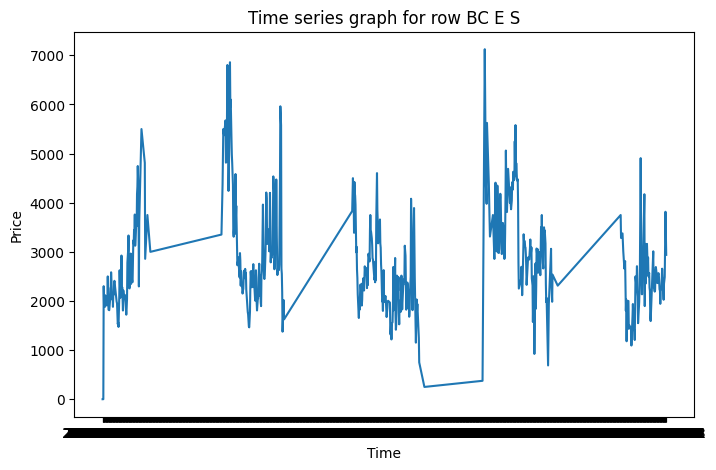

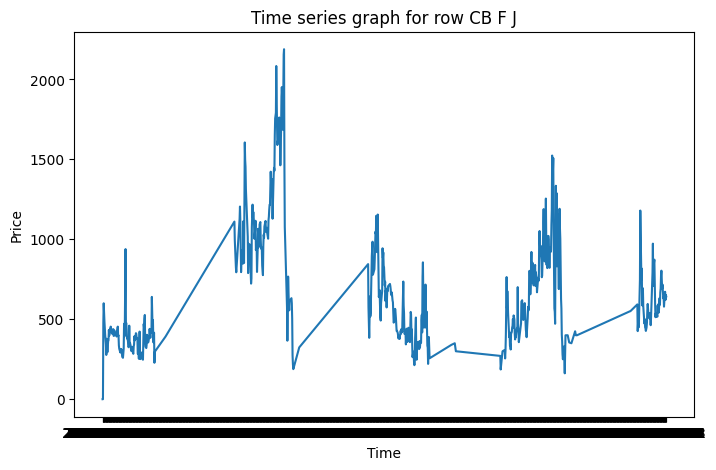

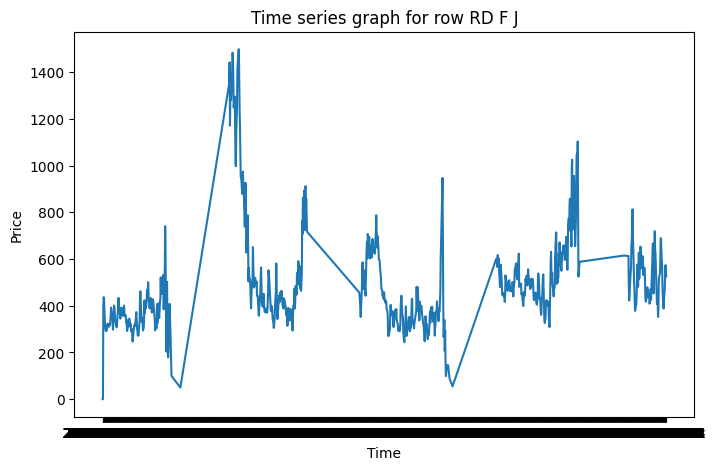

In [43]:
import matplotlib.pyplot as plt
for i in range(39):  # i는 0에서 38까지
    plt.figure(figsize=(8, 5))
    # plt.plot(price_df.iloc[i, 5:])
    plt.plot(price_df.columns[5:], price_df.iloc[i, 5:])  # x축에 시간(열 이름)을 표시
    plt.title(f"Time series graph for row {price_df.iloc[i, 4]}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

# Model Train

In [101]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

In [102]:
# Function to reshape the data into a time series format for each ID
def reshape_data(df):
    time_series_data = []
    for idx, row in df.iterrows():
        sales_data = row[5:].values.astype(float)
        time_series_data.append(sales_data)
    return np.array(time_series_data)

# Modified time_slide_df function to work with the current data format
def time_slide_df(data, window_size, forecast_size):
    data_list = []
    dap_list = []
    for idx in range(0, len(data) - window_size - forecast_size + 1):
        x = data[idx:idx + window_size].reshape(window_size, 1)
        y = data[idx + window_size:idx + window_size + forecast_size]
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

# Function to create DataLoader for each ID
def create_dataloader(data, window_size, forecast_size, batch_size):
    X, Y = time_slide_df(data, window_size, forecast_size)
    #현재는 1432,64,1에 1432,28의 형태이지만 추가 데이터가 들어가서 1432,윈도우사이즈,5~8 에 1432,28의 형태가 되어야 해 
    
    ds = Data(X, Y)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# Reshape the data
time_series_data = reshape_data(price_df)

In [84]:
len(time_series_data[0])

1523

In [103]:
# Define the window size, forecast size, and batch size
window_size = 64  
forecast_size = 28
batch_size = 2048
epoch_count = 777
lr = 0.0015
min_delta = 0.001
patience = 15

In [114]:
class AsymmetricMSELoss(nn.Module):
    def __init__(self, alpha = 0.45):
        super(AsymmetricMSELoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        diff = predictions - targets
        squared_diff = diff ** 2
        loss = torch.where(diff >= 0, self.alpha * squared_diff, (1 - self.alpha) * squared_diff)
        return loss.mean()

# Model Train


In [115]:

future_predictions_by_id = {}
loss_history = {}
# Iterate through the data by ID
for idx, (id_val, data) in tqdm(enumerate(zip(price_df["item"], time_series_data)), total=len(price_df["item"])):
    mean_ = np.mean(data)
    std_ = np.std(data)
    if std_ == 0:
        standardized_data = data
    else:
        standardized_data = (data - mean_) / std_

    individual_loss_history = []
    # Create DataLoader
    
    train_dl = create_dataloader(standardized_data, window_size, forecast_size, batch_size)
    # print(train_dl)
    best_loss = float('inf')
    no_improvement_count = 0

    # Training the model
    DLinear_model = LTSF_NLinear(window_size=window_size, forecast_size=28, individual=False, feature_size=1)
    DLinear_model.to(device)
    # criterion = nn.MSELoss()
    criterion = AsymmetricMSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    for epoch in range(1, epoch_count + 1):
        loss_list = []
        DLinear_model.train()
        for batch_idx, (data, target) in enumerate(train_dl):
            data, target = data.to(device), target.to(device)  # Move the data to the GPU if available
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        if((epoch % 10) == 0):
            avg_loss = np.mean(loss_list)
            #print(f"Id {idx}, Epoch {epoch}: Loss = {avg_loss}")
            individual_loss_history.append(avg_loss)
            if avg_loss + min_delta < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= patience:
                    #print(f"Early stopping at epoch {epoch} for ID {id_val}")
                    break


    loss_history[id_val] = individual_loss_history

    last_window_data = torch.tensor(standardized_data[-window_size:]).unsqueeze(0).unsqueeze(-1).float().to(device)
    future_prediction = DLinear_model(last_window_data)

    if std_ == 0:
        future_prediction = future_prediction.squeeze().detach().cpu().numpy()
    else:
        future_prediction = future_prediction.squeeze().detach().cpu().numpy() * std_ + mean_

    # Store the prediction
    future_predictions_by_id[id_val] = future_prediction

# Future predictions for each ID from 2023-04-05 to 2023-04-25
future_predictions_by_id

  0%|          | 0/39 [00:00<?, ?it/s]

{'TG A J': array([2892.612 , 1338.6116, 2646.8716, 2954.1033, 2789.7837, 3284.7688,
        3001.9626, 2743.3418, 1086.0474, 2394.725 , 2923.228 , 2543.4448,
        3243.0193, 3147.958 , 2916.4038, 1383.6135, 2722.4968, 3097.0852,
        3028.959 , 3343.1191, 2931.4346, 2773.0728, 1230.5989, 2675.537 ,
        2989.1262, 2772.166 , 3240.6226, 3160.9316], dtype=float32),
 'TG A S': array([4104.6353 ,  958.28467, 3372.7534 , 3853.766  , 4093.3064 ,
        4010.311  , 4066.0886 , 4303.3657 , 1110.8718 , 3949.795  ,
        3988.608  , 4312.8633 , 3899.513  , 3724.1755 , 4457.2437 ,
        1150.605  , 3470.3645 , 3883.0266 , 4379.2036 , 4038.1912 ,
        4147.9214 , 4208.684  , 1079.0955 , 3834.5361 , 3991.1982 ,
        4044.2375 , 4175.4287 , 4240.477  ], dtype=float32),
 'TG B J': array([3086.1467, 1431.8057, 3141.4907, 2420.814 , 3652.0388, 3789.1238,
        3363.4187, 2933.401 ,  763.7883, 2711.7363, 3441.348 , 3786.7761,
        4176.2036, 3747.1926, 2941.179 , 1221.4785, 2909

In [116]:
submit = pd.read_csv('./../../DATA/sample_submission.csv')
submit

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [117]:
findata = []
for id_val, predictions in future_predictions_by_id.items():
    rounded_predictions = np.round(predictions).astype(np.float64)
    findata.extend(rounded_predictions)

submit['answer'] = findata
submit.loc[submit['answer'] <= 0, 'answer'] = 0
submit.loc[submit.index % 7 == 1, 'answer'] = 0

In [118]:
submit.head(30)

,ID,answer
0,TG_A_J_20230304,2893.0
1,TG_A_J_20230305,0.0
2,TG_A_J_20230306,2647.0
3,TG_A_J_20230307,2954.0
4,TG_A_J_20230308,2790.0
5,TG_A_J_20230309,3285.0
6,TG_A_J_20230310,3002.0
7,TG_A_J_20230311,2743.0
8,TG_A_J_20230312,0.0
9,TG_A_J_20230313,2395.0


In [113]:
submit.to_csv('../../DATA/SUBMIT/Nlinear_customloss.csv', index=False)

In [68]:
submit2= pd.read_csv('./../../DATA/SUBMIT/Dlinear1.csv')
submit2

,ID,answer
0,TG_A_J_20230304,2750.0
1,TG_A_J_20230305,0.0
2,TG_A_J_20230306,2548.0
3,TG_A_J_20230307,2915.0
4,TG_A_J_20230308,2700.0
...,...,...
1087,RD_F_J_20230327,363.0
1088,RD_F_J_20230328,378.0
1089,RD_F_J_20230329,403.0
1090,RD_F_J_20230330,362.0


In [26]:
sub2 = submit2
sub2['answer'] = sub2['answer']+submit['answer']

In [28]:
sub2['answer'] = sub2['answer']/2

In [30]:
sub2.to_csv('../../DATA/SUBMIT/D+Llinear.csv', index=False)

In [61]:
subb = pd.read_csv('../../DATA/SUBMIT/Nlinear2.csv')
subb.head(30)

,ID,answer
0,TG_A_J_20230304,2734.0
1,TG_A_J_20230305,0.0
2,TG_A_J_20230306,2491.0
3,TG_A_J_20230307,2870.0
4,TG_A_J_20230308,2593.0
5,TG_A_J_20230309,3121.0
6,TG_A_J_20230310,2818.0
7,TG_A_J_20230311,2602.0
8,TG_A_J_20230312,0.0
9,TG_A_J_20230313,2305.0


In [70]:
subb.to_csv('../../DATA/SUBMIT/Nlinear2_weekavg.csv', index=False)